In [64]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using DifferentialEquations

In [356]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 3.3
M = 15
beta = 4.6
alpha = 1.2
gamma = 0.0
D = 0.01
Nh = 3 * 10^6

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(length(x)/2)] = 20/dx
# viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=false)
# population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density)

# Create Network instance
migration_matrix = [0.0][:,:] # Define an appropriate migration matrix
network = Network([population], migration_matrix)

# Create Simulation instance
dt = 0.01 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration)

# Run the simulation
@time run_simulation!(simulation)


 83.206191 seconds


true

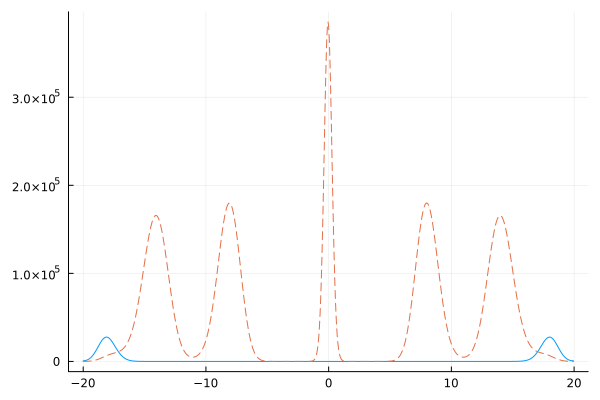

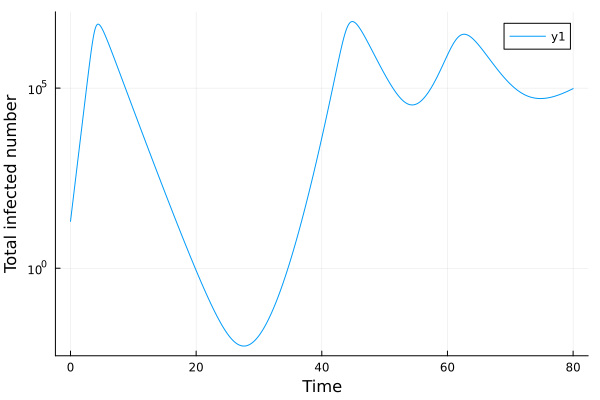

In [357]:
p = plot()
reg = population.xs .> 0
for i = length(simulation.duration_times)
    plot!(p, population.xs, simulation.trajectory[i].populations[1].viral_density,legend=false)
end
plot!(p, population.xs, Nh .* simulation.trajectory[end].populations[1].immune_density, legend=false, linestyle=:dash)
display(p)

# Assuming the relevant data structures are present
num_timepoints = length(simulation.duration_times)
avg_antigenicity = Vector{Float64}(undef, num_timepoints)
variance_antigenicity = Vector{Float64}(undef, num_timepoints)

for i = 1:num_timepoints
    viral_densities = simulation.trajectory[i].populations[1].viral_density
    total_density = sum(viral_densities[reg])
    
    # Average antigenicity for the current time point
    avg_antigenicity[i] = sum(population.xs[reg] .* viral_densities[reg]) / total_density
    
    # Variance calculation for the current time point
    deviations = population.xs[reg] .- avg_antigenicity[i]
    variance_antigenicity[i] = sum((deviations .^ 2) .* viral_densities[reg]) / total_density
end

# Plotting the average and variance over time
using Plots

p1 = plot(simulation.duration_times, avg_antigenicity, label="Average Antigenicity", xlabel="Time", ylabel="Value", legend=:topright)
p2 = plot(simulation.duration_times, variance_antigenicity, label="Variance of Antigenicity", xlabel="Time", ylabel="Value", legend=:topright)

plot(p1, p2, layout=(2,1))

p = plot()
plot!(p,simulation.duration_times,calculate_total_infected(simulation),yscale=:log10)
xlabel!("Time")
ylabel!("Total infected number")

Found S_f: 0.023695711727345112
Found H_f: 0.220807702986631

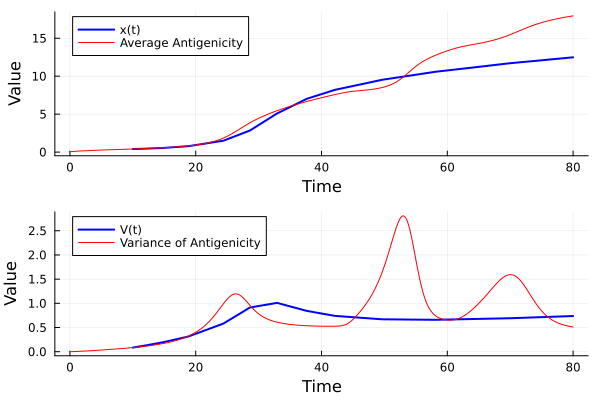

In [369]:

# Given parameter R_0
R_0 = beta/(alpha + gamma)  # Change this to your actual R_0

# Define the function for the iteration
function next_S(S)
    return exp(-R_0 * (1-S))
end

# Fixed-point iteration to find S_f
Sf_initial_guess = 0.5
S_previous = Sf_initial_guess
tolerance = 1e-6
max_iterations = 1000
iteration = 0

while iteration < max_iterations
    S_next = next_S(S_previous)
    
    # Break if the change is below the tolerance
    if abs(S_next - S_previous) < tolerance
        break
    end
    
    S_previous = S_next
    iteration += 1
end

S_f = S_previous
H_f = 1 - S_f^(1/M)

println("Found S_f: ", S_f)
println("Found H_f: ", H_f)
c(x) = H_f * exp(-x/r)
S(x) = (1-c(x))^M

# System of ODEs
function system!(du, u, p, t)
    x, V = u

    dS_dx = (exp(-x/r) * M * H_f * (1 - exp(-x/r) * H_f)^(-1 + M)) / r
    d2S_dx2 = (M * H_f * (1 - exp(-x/r) * H_f)^M * (-exp(x/r) + M * H_f)) / (r^2 * (exp(x/r) - H_f)^2)

    du[1] = V * beta * dS_dx
    du[2] = 2 * D + beta * d2S_dx2 * V^2
end

# Initial conditions and time span
tstart = 10.0;
if tstart > 0
    indexstart = argmin(abs.(simulation.duration_times .- tstart))
    u0 = [avg_antigenicity[indexstart], variance_antigenicity[indexstart]]  # Example initial conditions for x and V
else
    indexstart = 1
    u0 = [0.0, 0.0]
end
tspan = (tstart, duration)

# Solve the system
prob = ODEProblem(system!, u0, tspan)
sol = solve(prob)

# Plotting the ODE solution for x(t) and overlaying the average antigenicity
p1 = plot(sol.t, sol[1,:], label="x(t)", lw=2, xlabel="Time", ylabel="Value", legend=:topleft, color=:blue)
plot!(p1, simulation.duration_times, avg_antigenicity, label="Average Antigenicity", color=:red)

# Plotting the ODE solution for V(t) and overlaying the variance of antigenicity
p2 = plot(sol.t, sol[2,:], label="V(t)", lw=2, xlabel="Time", ylabel="Value", legend=:topleft, color=:blue)
plot!(p2, simulation.duration_times, variance_antigenicity, label="Variance of Antigenicity", color=:red)

# Combine the two plots in a 2x1 layout
plot(p1, p2, layout=(2,1))



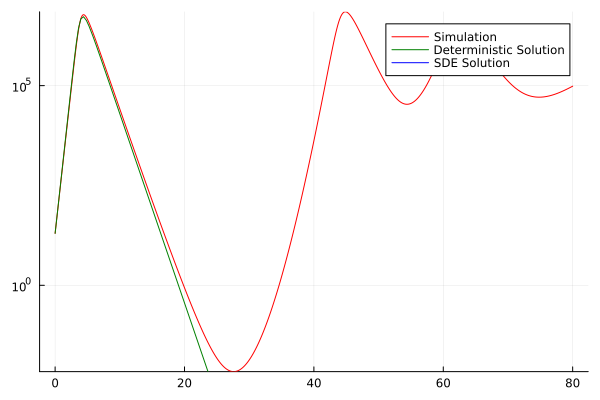

In [371]:
function deterministic_ode!(du, u, p, t)
    N, S = u
    Nh, beta, alpha, gamma = p

    du[1] = (beta * S - alpha - gamma) * N  # dN/dt
    du[2] = -N/Nh * S                       # dS/dt
end
initial_N = calculate_total_infected(simulation)[1]  # Assuming N0 is your initial value for total infected number.
initial_S = 1.0 # Your initial susceptible population. Set this value.

params = [Nh, beta, alpha, gamma]

deterministic_tspan = (0.0, duration)
initial_conditions = [initial_N, initial_S]

det_prob = ODEProblem(deterministic_ode!, initial_conditions, deterministic_tspan, params)
det_sol = solve(det_prob)


using Interpolations
tspan = (tstart, duration)
indexstart = argmin(abs.(simulation.duration_times .- tstart))

x_interp = linear_interpolation(sol.t,sol[1,:])
V_interp = linear_interpolation(sol.t,sol[2,:])

function drift(N, p, t)
    return (beta * S(x_interp(t)) - alpha - gamma + 0.5 * beta * d2S_dx2(x_interp(t), M, H_f, r) * V_interp(t)) * N
end

function diffusion(N, p, t)
    return 0.0 * sqrt(abs(N))
end


function condition(out, N, t, integrator)
    N < 1e-6  # replace `threshold` with the desired cutoff value
end

function affect!(integrator)
    integrator.u = 0.0
end

function d2S_dx2(x, M, H_f, r)
    return (M * H_f * (1 - exp(-x/r) * H_f)^M * (-exp(x/r) + M * H_f)) / (r^2 * (exp(x/r) - H_f)^2)
end


reset_callback = ContinuousCallback(condition, affect!)

# N0 = calculate_total_infected(simulation)[indexstart]  # taking the initial infected number from the simulated value
N0 = det_sol[1,end]
prob_sde = SDEProblem(
    drift, 
    diffusion, 
    N0, 
    tspan
)

sol_sde = solve(prob_sde, EM(), callback=reset_callback, dt=dt)  # using Euler–Maruyama method for SDEs
infected_data = calculate_total_infected(simulation)
y_min = minimum(infected_data)
y_max = maximum(infected_data)

plot(simulation.duration_times, infected_data, label="Simulation", color=:red, ylim=(y_min, y_max), yscale=:log10)
plot!(det_sol.t, det_sol[1,:], label="Deterministic Solution", color=:green)
plot!(sol_sde.t, sol_sde.u, label="SDE Solution", color=:blue)



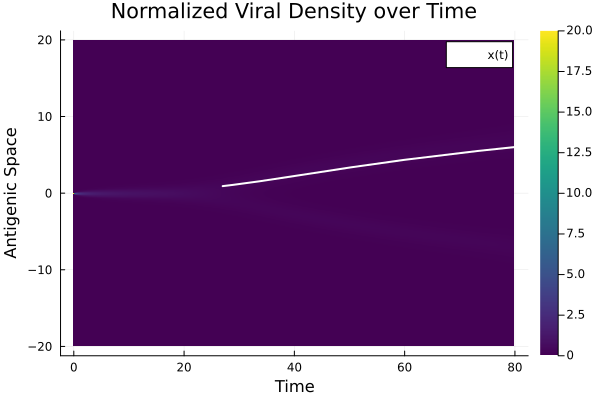

In [328]:
plot_normalized_spacetime_density(simulation, sol)

In [160]:
function plot_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain
    
    z = hcat([network.populations[1].viral_density for network in simulation.trajectory]...) # viral densities over time
    
    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Viral Density over Time"
    )
end

function plot_normalized_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(t.populations[1].viral_density ./ tot) for (t, tot) in zip(simulation.trajectory, tot_infected)]...) # normalized viral densities over time

    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
end

function plot_normalized_spacetime_density(simulation, sol)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(tot > 0 ? t.populations[1].viral_density ./ tot : zeros(size(t.populations[1].viral_density))) 
              for (t, tot) in zip(simulation.trajectory, tot_infected)]...) 
    # normalized viral densities over time or zeros if total infected is 0

    # Plotting
    p = heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
    
    # Overlaying the solution for the mean antigenicity
    plot!(p, sol.t, sol[1,:], lw=2, label="x(t)", color=:white, legend=:topright)

    return p
end


plot_normalized_spacetime_density (generic function with 2 methods)